<a href="https://colab.research.google.com/github/EmperorNao/MLHub/blob/main/examples/LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from math import ceil
import matplotlib.pyplot as plt

In [ ]:
class DimensionsException(Exception):

    def __init__(self, s):
        self.msg = s
        super().__init__()

    def __str__(self):
        return self.msg

In [ ]:
def rmse(y_real: np.ndarray, y_pred: np.ndarray) -> float:

    return np.sum(np.square(y_real - y_pred)) / y_real.shape[0]


def mse(y_real: np.ndarray, y_pred: np.ndarray) -> float:

    return np.sum(np.abs(y_real - y_pred)) / y_real.shape[0]

In [ ]:
def train_test_split(x: np.ndarray,
                     y: np.ndarray,
                     ratio: float = 0) -> ((np.ndarray, np.ndarray), (np.ndarray, np.ndarray)):

    if x.shape[0] != y.shape[0]:
        raise DimensionsException("X and y has different number of objects")

    if 1 < ratio < 0:
        raise ValueError(f"Ratio need to be in [0, 1], provided {ratio}")

    idx_full = range(0, x.shape[0])
    size = ceil(x.shape[0] * ratio)
    idx_train = list(np.random.choice(idx_full, size))
    idx_test = list(set(idx_full).difference(idx_train))

    return (x[idx_train, :], x[idx_test, :]), (y[idx_train, :], y[idx_test, :])

In [ ]:
import numpy as np


def sgd(x: np.ndarray,
        y: np.ndarray,
        loss_fn, grad_loss_fn,
        lr = 1e-4,
        smart_init=False,
        w: np.ndarray = None,
        lam: float = 0.9,
        eps=1e-6,
        batch_size=1, # менять bs нельзя, данный метод не работает для нескольких элементов в батче
        max_iter=10000) -> (np.ndarray, float):

    n_features = x.shape[1]
    n_objects = x.shape[0]

    if w is None:
        if not smart_init:
            w = np.zeros(n_features)
            for i in range(n_features):
                w[i] = np.random.normal(0, 1 / (2 * x.shape[0]))

    w = np.expand_dims(w, -1)

    grad_coef = np.asarray([grad_loss_fn(w, np.expand_dims(x[i], axis=0), y[i]) for i in range(n_objects)])
    grad_sum = np.sum(grad_coef, axis=0)

    delta_q = float("inf")
    delta_w = np.array([float("inf")] * n_features)
    loss = loss_fn(w, x, y)
    q = np.sum(loss) / x.shape[0]

    iter = 0
    while iter < max_iter and (abs(delta_q) > eps or abs(np.sum(delta_w)) > (eps * n_features)):

        idx_obj = np.random.choice(range(n_objects), size=batch_size)
        x_obj = x[idx_obj,:]
        y_obj = y[idx_obj]

        loss = np.sum(loss_fn(w, x_obj, y_obj)) / x_obj.shape[0]

        grad = grad_loss_fn(w, x_obj, y_obj)
        grad_sum -= grad_coef[idx_obj[0]]
        grad_coef[idx_obj[0]] = grad
        grad_sum += grad_coef[idx_obj[0]]

        delta_w = lr * grad_sum / n_objects
        w = w - delta_w

        new_q = lam * loss + (1 - lam) * q
        delta_q = new_q - q
        q = new_q

        iter += 1

    return w, q


class SGDOptimizer:

    def __init__(self,
                lr: float =1e-4,
                smart_init=False,
                w: np.ndarray = None,
                lam: float = 0.9,
                eps = 1e-6,
                max_iter = 10000):

        self.lr = lr
        self.smart_init = smart_init
        self.w = w
        self.lam = lam
        self.eps = eps
        self.max_iter = max_iter

    def fit(self,
            x: np.ndarray,
            y: np.ndarray,
            loss_fn,
            grad_loss_fn) -> (np.ndarray, float):
            # weight and quality

        return sgd(x, y, loss_fn, grad_loss_fn,
                   self.lr, self.smart_init, self.w, self.lam, self.eps, 1, self.max_iter)


In [ ]:

class LinearRegression:
    # L(w, X, y) = (X*w - y) ^ 2
    # x.shape = (l, n)
    # w.shape = (n, 1)
    # y.shape = (l, 1)
    # dL/dw = 2 * X.T * (X*w - y)
    # dL/dw.shape = (l, 1)

    def __init__(self, weights: np.ndarray = None, optimizer=None, L2_coefficient: float = 0,
                 analytic_solution=True):

        self.weights = weights
        self.optimizer = optimizer
        self.L2_coefficient = L2_coefficient
        self.analytic_solution = analytic_solution

    def fit(self, x: np.ndarray, y: np.ndarray):

        if x.shape[0] != y.shape[0]:
            raise DimensionsException("X and y has different number of objects")

        n_objects = x.shape[0]
        n_features = x.shape[1] + 1
        ones = 1 * np.ones((n_objects, 1))

        x_padded = np.hstack([x, ones])

        l_i = np.eye(n_features, n_features)

        if self.analytic_solution or not self.optimizer:
            w = np.dot(np.linalg.inv(np.dot(x_padded.T, x_padded) + self.L2_coefficient * l_i), np.dot(x_padded.T, y))
        else:
            w, q = self.optimizer.fit(x_padded, y, self.loss, self.grad_loss)
        self.weights = w

    def loss(self, w: np.ndarray, x: np.ndarray, y: np.ndarray):
        # x.shape = m x n
        # y.shape = m x 1
        # w.shape = n x 1

        return np.square(np.dot(x, w) - y)

    def grad_loss(self, w: np.ndarray, x: np.ndarray, y: np.ndarray):
        # x.shape = m x n
        # y.shape = m x 1
        # w.shape = n x 1
        # out shape = ((m x n) * (n x 1) - (m x 1)) = (n x m) * (m x 1) = (n x 1)

        return 2 * np.dot(x.T, (np.dot(x, w) - y))

    def predict(self, x: np.ndarray) -> np.ndarray:

        n_objects = x.shape[0]
        ones = 1 * np.ones((n_objects, 1))
        x_padded = np.hstack([x, ones])

        if x_padded.shape[1] != self.weights.shape[0]:
            raise DimensionsException("Wrong number of features")

        return np.dot(x_padded, self.weights)

Scale = 0
RMSE
RMSE on SLKEARN = 1.195452963453675e-27
RMSE on our LR = 6.642344407429004e-27
RMSE on LR + L2_reg = 1.017758578943296
RMSE on SGD = 1.017758578943296
MSE
MSE on SKLEARN = 1.491399596413127e-14
MSE on our LR = 7.095250313208605e-14
MSE on LR + L2_reg = 0.8541987387146347
MSE on SGD = 0.8541987387146347



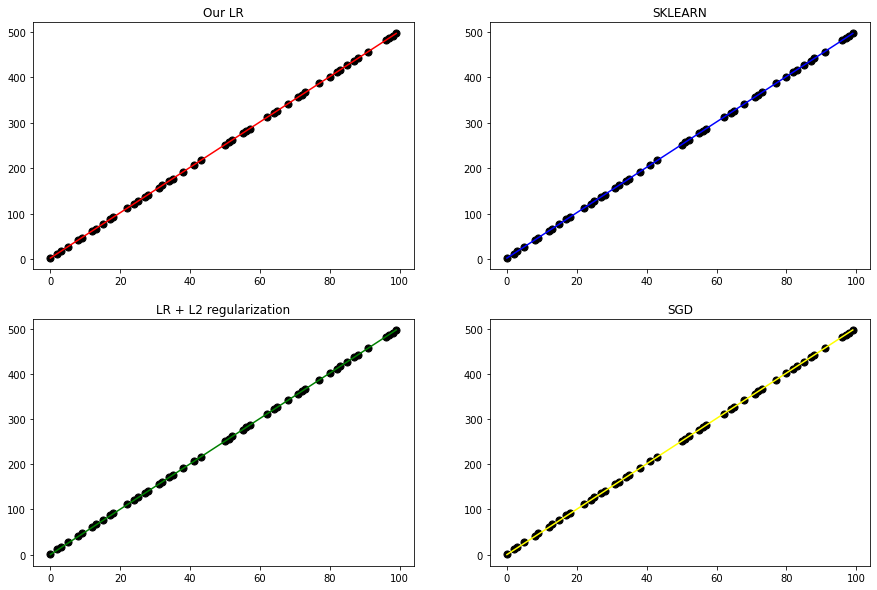

Scale = 1.41
RMSE
RMSE on SLKEARN = 2.271947668726135
RMSE on our LR = 2.271947668726108
RMSE on LR + L2_reg = 3.6169622386695304
RMSE on SGD = 3.6169622386695304
MSE
MSE on SKLEARN = 1.1145643690513114
MSE on our LR = 1.1145643690512939
MSE on LR + L2_reg = 1.4759372689055814
MSE on SGD = 1.4759372689055814



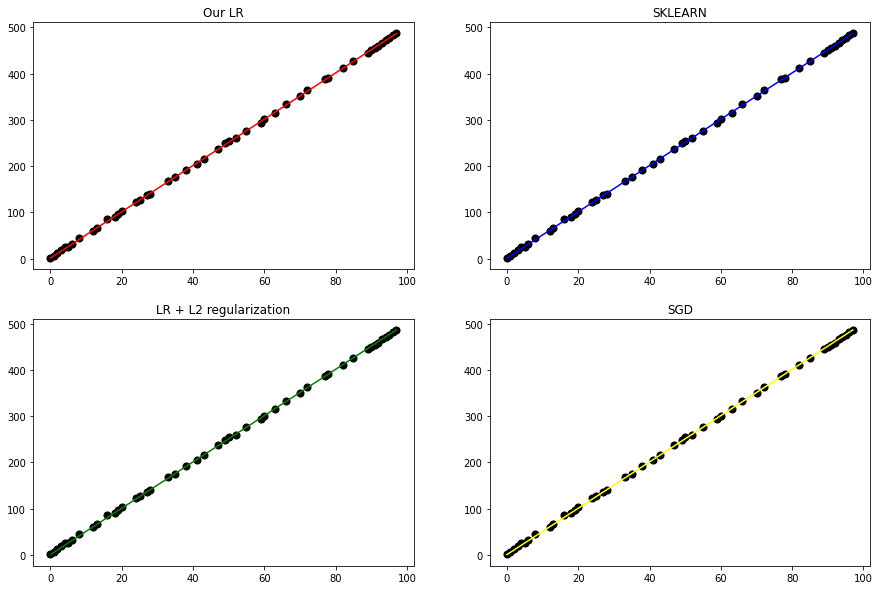

Scale = 4
RMSE
RMSE on SLKEARN = 14.903105341148372
RMSE on our LR = 14.903105341148606
RMSE on LR + L2_reg = 13.87336297898553
RMSE on SGD = 13.87336297898553
MSE
MSE on SKLEARN = 3.1612898642452745
MSE on our LR = 3.161289864245288
MSE on LR + L2_reg = 3.074316687964157
MSE on SGD = 3.074316687964157



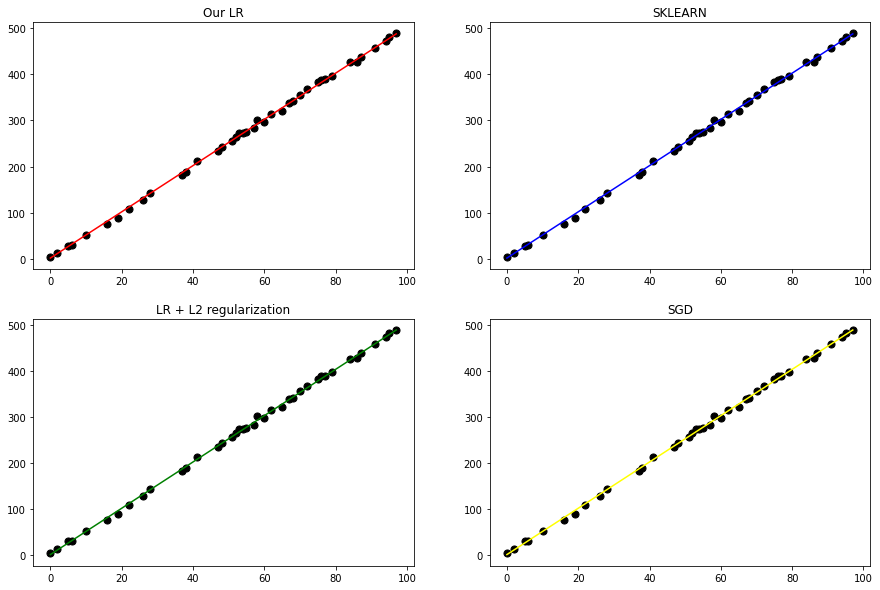

Scale = 9
RMSE
RMSE on SLKEARN = 75.97342484362866
RMSE on our LR = 75.97342484362845
RMSE on LR + L2_reg = 73.3564803485663
RMSE on SGD = 73.3564803485663
MSE
MSE on SKLEARN = 7.322819466238336
MSE on our LR = 7.322819466238334
MSE on LR + L2_reg = 7.185212557546889
MSE on SGD = 7.185212557546889



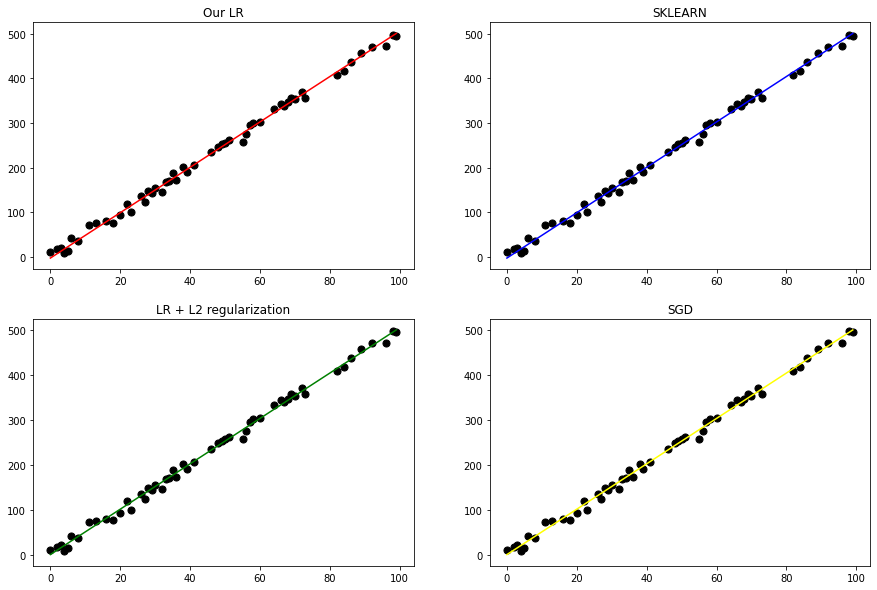

Scale = 25
RMSE
RMSE on SLKEARN = 500.51489927289026
RMSE on our LR = 500.5148992728879
RMSE on LR + L2_reg = 491.3506161579336
RMSE on SGD = 491.3506161579336
MSE
MSE on SKLEARN = 17.65915304810519
MSE on our LR = 17.659153048105182
MSE on LR + L2_reg = 17.733408949888105
MSE on SGD = 17.733408949888105



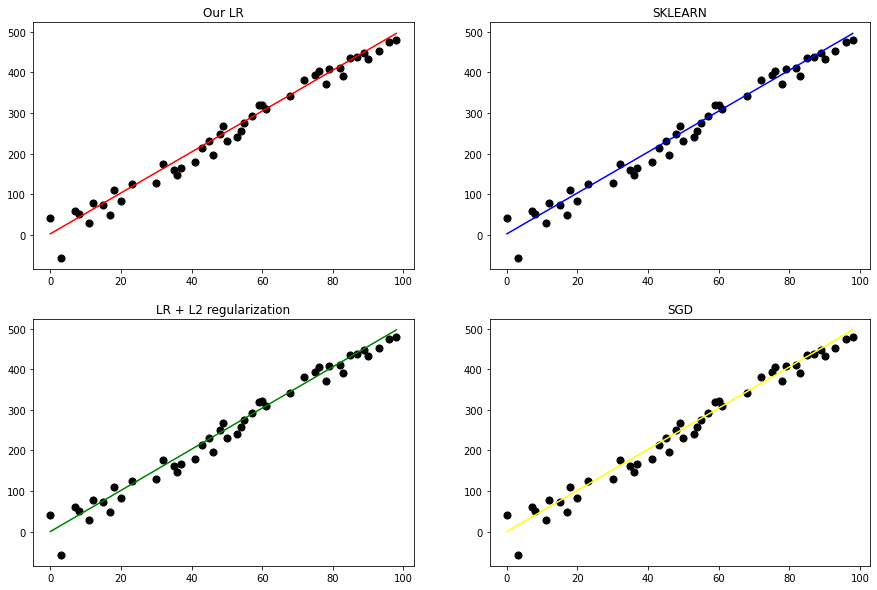

Scale = 36
RMSE
RMSE on SLKEARN = 1622.2224779796015
RMSE on our LR = 1622.2224779796038
RMSE on LR + L2_reg = 1628.4480810934558
RMSE on SGD = 1628.4480810934558
MSE
MSE on SKLEARN = 30.63394933714806
MSE on our LR = 30.633949337148024
MSE on LR + L2_reg = 30.598158358800827
MSE on SGD = 30.598158358800827



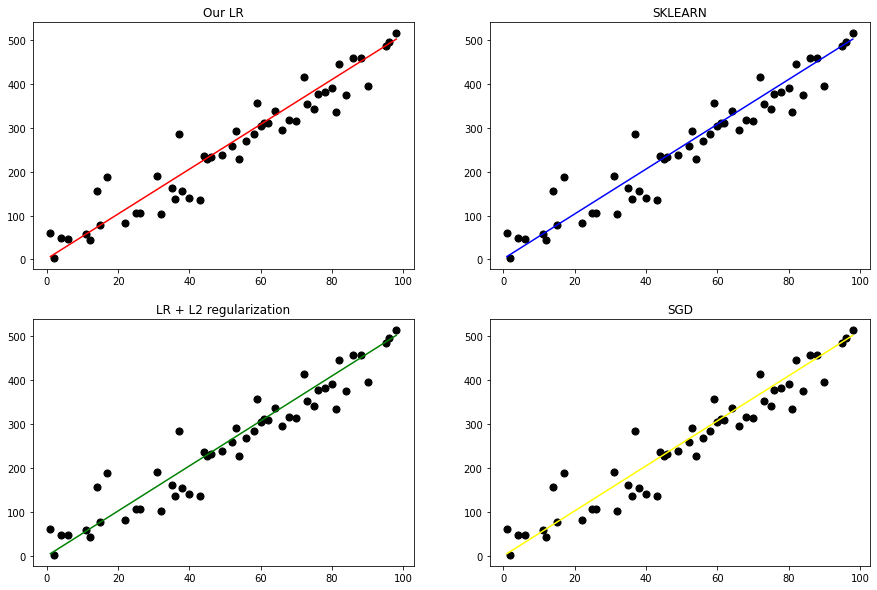

Scale = 100
RMSE
RMSE on SLKEARN = 9933.943645293732
RMSE on our LR = 9933.943645293723
RMSE on LR + L2_reg = 10286.336470355065
RMSE on SGD = 10286.336470355065
MSE
MSE on SKLEARN = 79.59691073293472
MSE on our LR = 79.59691073293465
MSE on LR + L2_reg = 81.94228763233393
MSE on SGD = 81.94228763233393



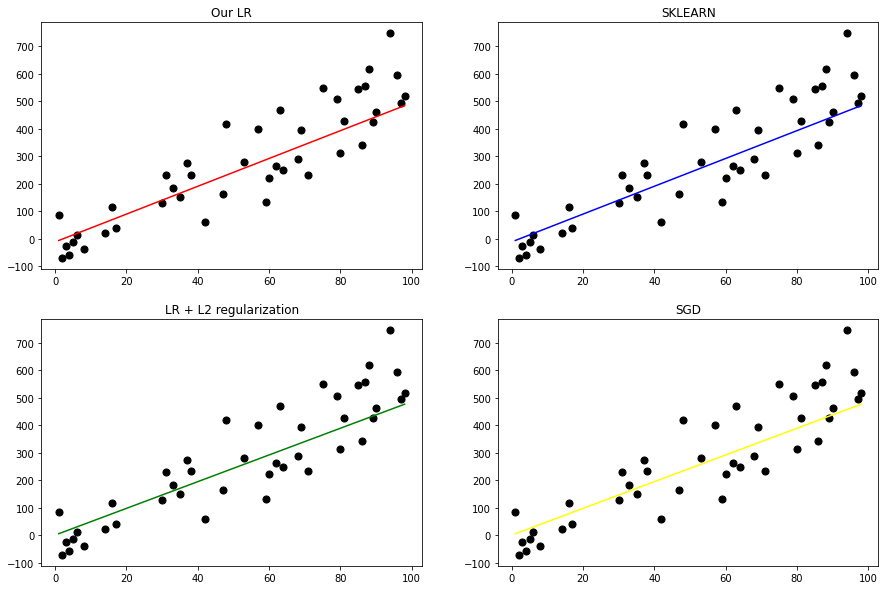

In [ ]:
from sklearn import linear_model

for scale in [0, 1.41, 4, 9, 25, 36, 100]:

    # max iter обеспечивает гораздо более лучшую сходимость
    # для улучшения качества пробуйте увеличить max_iter

    optim = SGDOptimizer(lr=1e-6, max_iter=10000)

    simple = LinearRegression()
    sklearn = linear_model.LinearRegression()
    l2_reg = LinearRegression(L2_coefficient=0.05)
    sgd_lr = LinearRegression(analytic_solution=False, optimizer=optim)

    N = 100
    #x, y = get_dataset("auto-mpg")
    pairs = np.array([np.array([i, i * 5 + 2 + np.random.normal(scale=scale)]) for i in range(0, N)])
    x = np.expand_dims(pairs[:, 0], -1)
    y = np.expand_dims(pairs[:, 1], -1)

    x_pair, y_pair = train_test_split(x, y, ratio=0.75)

    x_train, x_test = x_pair
    y_train, y_test = y_pair

    simple.fit(x_train, y_train)
    sklearn.fit(x_train, y_train)
    sgd_lr.fit(x_train, y_train)
    l2_reg.fit(x_train, y_train)

    y_pred_simple = simple.predict(x_test)
    y_pred_sklearn = sklearn.predict(x_test)
    y_pred_sgd = sgd_lr.predict(x_test)
    y_pred_l2_reg = sgd_lr.predict(x_test)

    print(f"Scale = {scale}")
    print("RMSE")
    print(f"RMSE on SLKEARN = {rmse(y_test, y_pred_sklearn)}")
    print(f"RMSE on our LR = {rmse(y_test, y_pred_simple)}")
    print(f"RMSE on LR + L2_reg = {rmse(y_test, y_pred_l2_reg)}")
    print(f"RMSE on SGD = {rmse(y_test, y_pred_sgd)}")

    print("MSE")
    print(f"MSE on SKLEARN = {mse(y_test, y_pred_sklearn)}")
    print(f"MSE on our LR = {mse(y_test, y_pred_simple)}")
    print(f"MSE on LR + L2_reg = {mse(y_test, y_pred_l2_reg)}")
    print(f"MSE on SGD = {mse(y_test, y_pred_sgd)}")
    print()

    n_obj = y_test.shape[0]

    fig = plt.figure(figsize = (15, 10))

    plt.subplot(2, 2, 1)
    plt.title("Our LR")
    plt.plot(x_test, y_pred_simple, color="red", label="simple")
    plt.scatter(x_test, y_test, color="black", s=50)

    plt.subplot(2, 2, 2)
    plt.title("SKLEARN")
    plt.plot(x_test, y_pred_sklearn, color="blue", label="sklearn")
    plt.scatter(x_test, y_test, color="black", s=50)

    plt.subplot(2, 2, 3)
    plt.title("LR + L2 regularization")
    plt.plot(x_test, y_pred_l2_reg, color="green", label="reg")
    plt.scatter(x_test, y_test, color="black", s=50)

    plt.subplot(2, 2, 4)
    plt.title("SGD")
    plt.plot(x_test, y_pred_sgd, color="yellow", label="sgd")
    plt.scatter(x_test, y_test, color="black", s=50)

    plt.show()